In [3]:
import os
import numpy as np
import random
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.generation import lattice
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, default_plot_setting, tree_plot_setting

from cascade_generator import si


In [4]:
random.seed(12345)
np.random.seed(12345)

In [5]:
sampling_method = 'loop_erased'
obs_fraction = 0.1
cascade_fraction = 1.0
cascade_model = 'si'
fig_dirname = 'figs/alg-illustration'



In [6]:
g = lattice((4, 4))
ug = GraphView(g, directed=False)

n = int(np.sqrt(g.num_vertices()))
pos = lattice_node_pos(g, shape=(n, n))

g.set_directed(True)
g.add_edge_list([(int(e.target()), int(e.source())) for e in g.edges()])
    

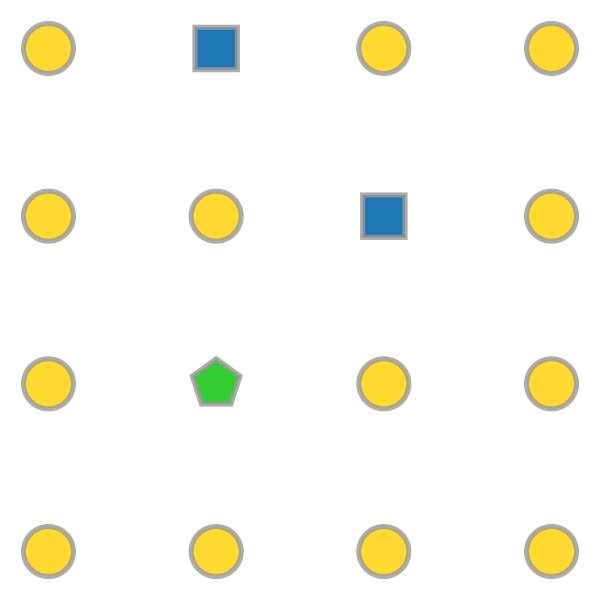

In [8]:
obs, c, true_tree = gen_input(g, source=6, stop_fraction=cascade_fraction, p=0.5, q=obs_fraction, return_tree=True)

inf_nodes = infected_nodes(c)
source = cascade_source(c)

node_size_mul = 4.0
edge_width_mul = 3.0

# plot cascade and observations

setting = default_plot_setting(ug, c, obs, size_multiplier=node_size_mul)
visualize(g, pos, **setting, output='{}/cascade.pdf'.format(fig_dirname))


In [9]:
gv = remove_filters(g)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=100,
    method=sampling_method,
    gi=gi,
    return_type='tuples',
    with_resampling=False,
    with_inc_sampling=False)
sampler.fill(obs, root_sampler=build_true_root_sampler(c))

In [10]:
samples = list(sorted(sampler.samples, key=len))

In [11]:
tree = samples[0]
tree

((4, 5), (5, 6), (9, 5))

In [12]:
def add_common_setting(s):
    s['node_text_info'][(obs[0], )] = 'A'
    s['node_text_info'][(obs[1], )] = 'B'

def node_draw_kwargs():
    return dict(
        vertex_font_size=36,
        vertex_text_offset=[0.24, 0.1],
        vertex_text_color='black'
    )

def edge_draw_kwargs():
    return dict(
        edge_font_size=40,
        edge_text_distance=10,
        edge_marker_size=40,
        edge_text_parallel=False
    )

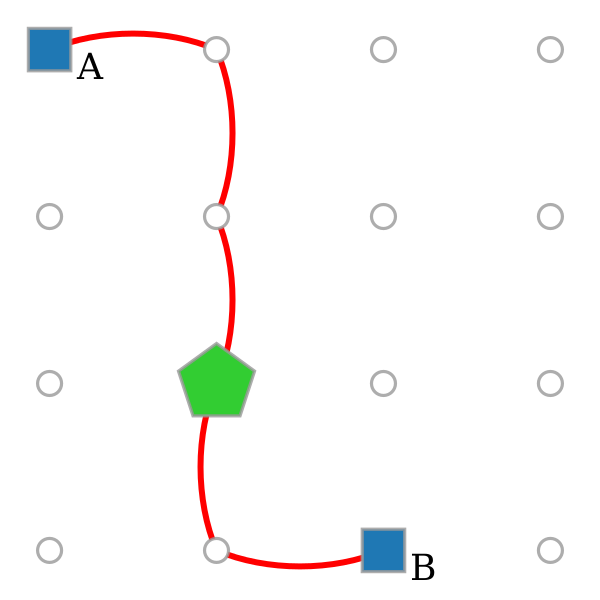

In [125]:
s = tree_plot_setting(ug, c, obs, tree,
                      size_multiplier=node_size_mul,
                      edge_width_multiplier=edge_width_mul,
                      deemphasize_hidden_infs=True)
add_common_setting(s)
visualize(
    ug, pos, **s, output="{}/output.pdf".format(fig_dirname, i),    
    **node_draw_kwargs()
)

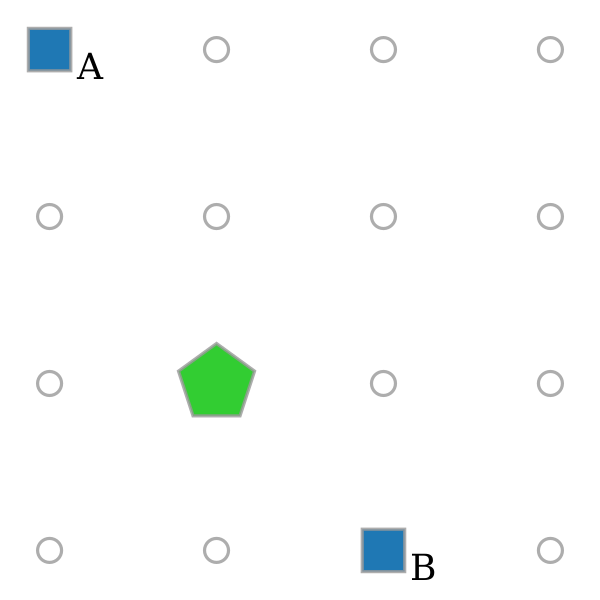

In [141]:
s = tree_plot_setting(ug, c, obs, tuple(),
                      size_multiplier=node_size_mul,
                      edge_width_multiplier=edge_width_mul,
                      deemphasize_hidden_infs=True)
add_common_setting(s)

visualize(
    ug, pos, **s, output="{}/initial.pdf".format(fig_dirname, i),
    **node_draw_kwargs()
)

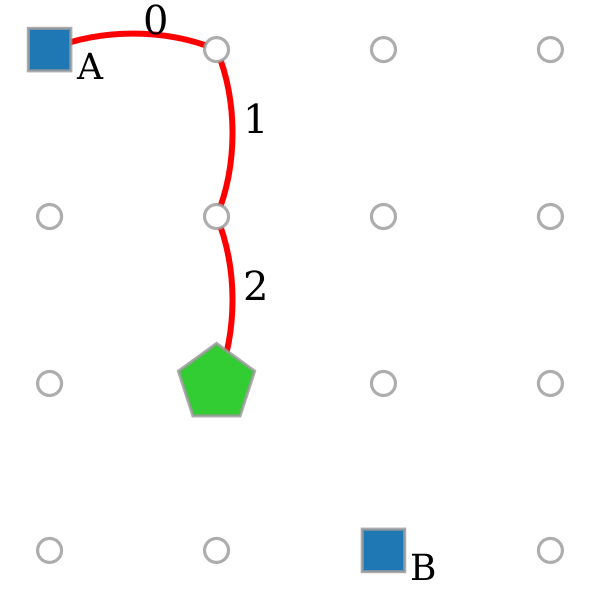

In [139]:
walks1 = ((0, 4), (4, 5), (5, 6))
s = tree_plot_setting(ug, c, obs, walks1,
                      size_multiplier=node_size_mul,
                      edge_width_multiplier=edge_width_mul,
                      deemphasize_hidden_infs=True)
edge_text = ug.new_edge_property('string')
for i, (u, v) in enumerate(walks1):
    edge_text[ug.edge(u, v)] = str(i)
    
add_common_setting(s)
visualize(
    ug, pos, **s, output="{}/lerw-step-1.pdf".format(fig_dirname, i),
    **node_draw_kwargs(),
    edge_text=edge_text,
    **edge_draw_kwargs()
)

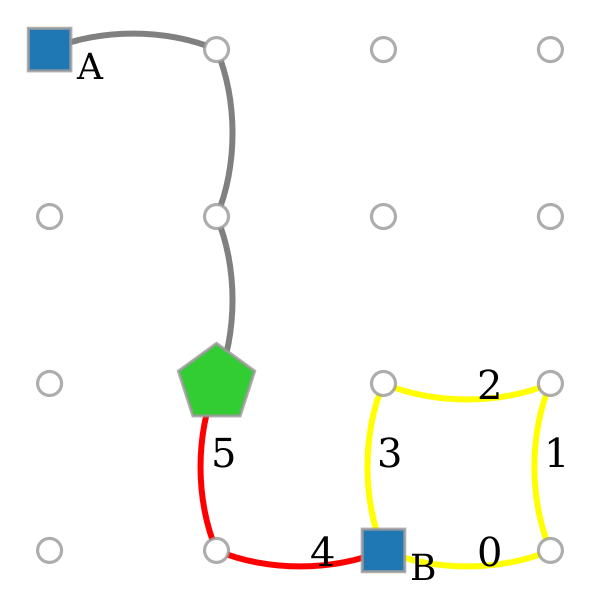

In [140]:
cycle = ((11, 15), (15, 14), (14, 10), (10, 11))
non_cycle = ((7, 6), (11, 7))[::-1]
walks = walks1 + cycle + non_cycle 
walks2 = cycle + non_cycle 
s = tree_plot_setting(ug, c, obs, walks,
                      size_multiplier=node_size_mul,
                      edge_width_multiplier=edge_width_mul,
                      deemphasize_hidden_infs=True)

s['edge_color_info'][walks1] = 'gray'
s['edge_color_info'][non_cycle] = 'red'
s['edge_color_info'][cycle] = 'yellow'
del s['edge_color_info'][walks]

edge_text = ug.new_edge_property('string')
for i, (u, v) in enumerate(walks2):
    edge_text[ug.edge(u, v)] = str(i)

add_common_setting(s)
visualize(
    ug, pos, **s, output="{}/lerw-step-2.pdf".format(fig_dirname, i),
    **node_draw_kwargs(),
    edge_text=edge_text,
    **edge_draw_kwargs()

)

In [36]:
tree = ((0, 4), (4, 5), (5, 6), (6, 7), (7, 11))
obs = (0, 11)
other_edges = ((0, 1), (2, 6), (3, 2), (5, 9), (9, 8), (8, 12), (9, 10), (10, 14), (14, 15), (12, 13))


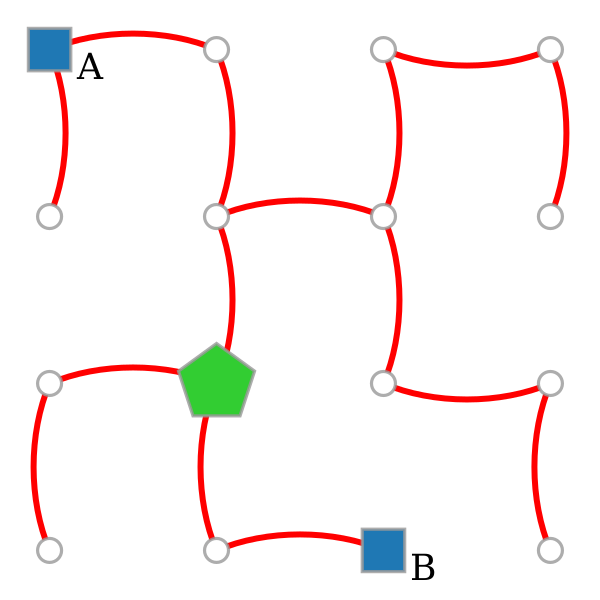

In [37]:
s = tree_plot_setting(ug, c, obs, tree + other_edges,
                      size_multiplier=node_size_mul,
                      edge_width_multiplier=edge_width_mul,
                      deemphasize_hidden_infs=True)
add_common_setting(s)

if False:
    for v in ug.vertices():
        s['node_text_info'][tuple([int(v)])] = str(v)
visualize(
    ug, pos, **s, output="{}/untrimmed.pdf".format(fig_dirname),    
    **node_draw_kwargs()
)

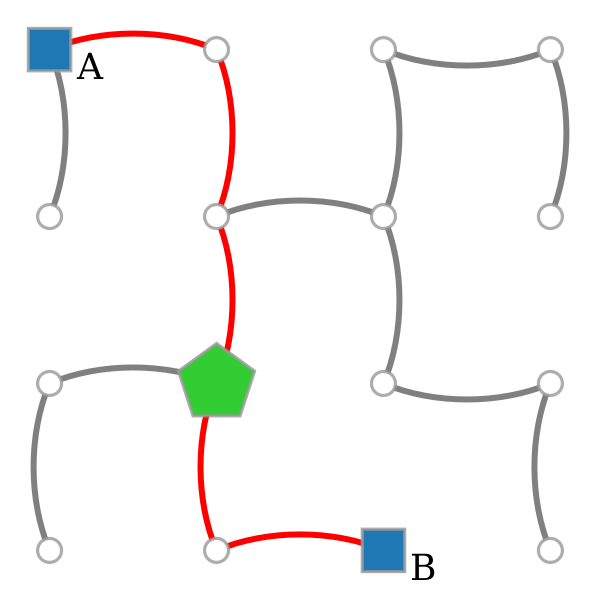

In [38]:
s = tree_plot_setting(ug, c, obs, tree + other_edges,
                      size_multiplier=node_size_mul,
                      edge_width_multiplier=edge_width_mul,
                      deemphasize_hidden_infs=True)
add_common_setting(s)

if False:
    for v in ug.vertices():
        s['node_text_info'][tuple([int(v)])] = str(v)
s['edge_color_info'][other_edges] = 'gray'
s['edge_color_info'][tree] = 'red'
del s['edge_color_info'][tree + other_edges]
visualize(
    ug, pos, **s, output="{}/untrimmed_colored.pdf".format(fig_dirname),    
    **node_draw_kwargs()
)